Installation of Tranform Library

In [1]:
!pip install -q transformers datasets torch scikit-learn pandas

# DistilBERT Customer Support Classification Model
A model trained to classify customer messages into predefined categories which includes accounts, billing, other and technical.

What this Model can be used for:


*  Ticket Routing: Automatically directing messages to the right department or agent (eg. teachnical team)

*  Response Prioritisation: Identify urgent or negative messages that needs quick attention.
*   Customer Analytics: Understand trends in complaints, feedback or issues over time.


*   Quality Monitoring: Classify messages for sentiment or compliance checks.



In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import torch
import pandas as pd
import numpy as np
import os

In [3]:
!pip install -q mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 752.6/752.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 6.2 MB/s eta 0:00:00


In [4]:
import mlflow
import os

# Set experiment name
mlflow.set_experiment("baseline_models")

# Define safe run starter to handle nested runs cleanly
def safe_start_run(run_name, nested=False):
    if mlflow.active_run() is not None:
        mlflow.end_run()
    return mlflow.start_run(run_name=run_name, nested=nested)

2025/11/03 18:19:29 INFO mlflow.tracking.fluent: Experiment with name 'baseline_models' does not exist. Creating a new experiment.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path = "/content/drive/MyDrive/clean_tickets.csv"
df = pd.read_csv(path)

print("Dataset overview:")
print(f"Total samples: {len(df)}")
print(f"\nLabels distribution:\n{df['label'].value_counts()}")
print(f"\nAgents distribution:\n{df['agent_name'].value_counts()}")


Dataset overview:
Total samples: 472

Labels distribution:
label
other        125
technical    119
account      115
billing      113
Name: count, dtype: int64

Agents distribution:
agent_name
Alice      132
Bob        120
Charlie    115
Dana       105
Name: count, dtype: int64


In [7]:
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from sentence_transformers import SentenceTransformer, util
import torch

# ==========================
# 1. Prepare the dataframe
# ==========================
df = df[['text', 'label']].copy()

# Encode labels (convert class names to numbers)
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

print(f"Initial samples: {len(df)}")

# ======================================================
# 2. Create semantic groups to prevent data leakage
# ======================================================
# Compute sentence embeddings using a lightweight transformer
model = SentenceTransformer("all-MiniLM-L6-v2")

print("🔍 Computing embeddings for semantic grouping...")
embeddings = model.encode(df['text'].tolist(), convert_to_tensor=True, show_progress_bar=True)

# Compute pairwise cosine similarity
cosine_sim = util.cos_sim(embeddings, embeddings)

# Cluster near-duplicates: if cosine similarity > threshold, they share a group
threshold = 0.9
group_ids = [-1] * len(df)
current_group = 0

for i in range(len(df)):
    if group_ids[i] != -1:
        continue
    group_ids[i] = current_group
    sims = cosine_sim[i]
    near_dups = torch.where(sims > threshold)[0].tolist()
    for j in near_dups:
        group_ids[j] = current_group
    current_group += 1

df['group'] = group_ids
print(f"✅ Created {len(set(group_ids))} semantic groups from {len(df)} samples.")

# ======================================================
# 3. Split using StratifiedGroupKFold (80/10/10)
# ======================================================
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# Take the first fold for test set
for train_val_idx, test_idx in sgkf.split(df, df['label'], groups=df['group']):
    train_val_df = df.iloc[train_val_idx]
    test_df = df.iloc[test_idx]
    break

# Now split train_val into train/val
sgkf_inner = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=42)
for train_idx, val_idx in sgkf_inner.split(train_val_df, train_val_df['label'], groups=train_val_df['group']):
    train_df = train_val_df.iloc[train_idx]
    val_df = train_val_df.iloc[val_idx]
    break

print(f"Train size: {len(train_df)} | Val size: {len(val_df)} | Test size: {len(test_df)}")
print(f"Unique groups: Train={train_df['group'].nunique()}, Val={val_df['group'].nunique()}, Test={test_df['group'].nunique()}")

# ======================================================
# 4. Check for data leakage between splits
# ======================================================
def check_data_leakage(train_df, test_df):
    overlap = set(train_df['text']).intersection(set(test_df['text']))
    print(f"Overlap count: {len(overlap)}")
    if len(overlap) > 0:
        print("⚠️ Data leakage detected!")
    else:
        print("✅ No overlap — group-aware split is clean.")

check_data_leakage(train_df, val_df)
check_data_leakage(train_df, test_df)
check_data_leakage(val_df, test_df)

# ======================================================
# 5. Convert to Hugging Face Dataset format
# ======================================================
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

print("✅ All datasets ready for DistilBERT fine-tuning!")



Initial samples: 472


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

🔍 Computing embeddings for semantic grouping...


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

✅ Created 78 semantic groups from 472 samples.
Train size: 276 | Val size: 105 | Test size: 91
Unique groups: Train=49, Val=16, Test=13
Overlap count: 0
✅ No overlap — group-aware split is clean.
Overlap count: 0
✅ No overlap — group-aware split is clean.
Overlap count: 0
✅ No overlap — group-aware split is clean.
✅ All datasets ready for DistilBERT fine-tuning!


# Essential Tools for the DistilBERT Model

Tools Include:
*   Tokenizer: Convert text (eg messages) to numbers (eg o's and 1's).
*   AutoTokenizer: Automatically picks the correct tokenizer for the pretrained DistilBERT.



In [29]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Set format for PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/276 [00:00<?, ? examples/s]

Map:   0%|          | 0/105 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

In [30]:
num_labels = len(df['label'].unique())

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
# ==========================================
# Compute Class Weights (to handle imbalance)
# ==========================================
class_counts = train_df['label'].value_counts().sort_index()
print("Class counts:\n", class_counts)

# Inverse frequency weighting
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_counts)
class_weights = torch.tensor(class_weights.values, dtype=torch.float)

# Move weights to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = class_weights.to(device)

print("Computed class weights:", class_weights)

Class counts:
 label
0    56
1    65
2    99
3    56
Name: count, dtype: int64
Computed class weights: tensor([1.1671, 1.0055, 0.6602, 1.1671])


In [32]:
# ==========================================
# Compute Class Weights (to handle imbalance)
# ==========================================
class_counts = train_df['label'].value_counts().sort_index()
print("Class counts:\n", class_counts)

# Inverse frequency weighting
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_counts)
class_weights = torch.tensor(class_weights.values, dtype=torch.float)

# Move weights to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = class_weights.to(device)

print("Computed class weights:", class_weights)

Class counts:
 label
0    56
1    65
2    99
3    56
Name: count, dtype: int64
Computed class weights: tensor([1.1671, 1.0055, 0.6602, 1.1671])


In [33]:
# ==========================================
# Custom Trainer with Weighted Loss
# ==========================================
import torch.nn as nn # Import the nn module

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Apply weighted CrossEntropyLoss
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

In [70]:

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,    # Train for 3–5 epochs
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs",
    report_to="none" # Explicitly disable reporting to wandb
)

In [71]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

/tmp/ipython-input-3441253692.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [72]:
os.environ["WANDB_DISABLED"] = "true"
trainer.train()

# Evaluate on the test dataset after training
trainer.evaluate(test_dataset)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,No log,0.821327
2,No log,0.892712
3,No log,0.963150
4,No log,0.964601
5,No log,0.979050


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument i

{'eval_loss': 0.8213274478912354,
 'eval_runtime': 16.7194,
 'eval_samples_per_second': 5.443,
 'eval_steps_per_second': 0.359,
 'epoch': 5.0}

os.environ["WANDB_DISABLED"] = "true"
trainer.train()

trainer.evaluate(test_dataset)

# Model Classification Report
Here processes and activity such as:

*   Manual defining of labels to encoders
*   Evaluation of Model classification performance using metrics such as precision, recall, f1-score and support.


*   Generation of a confusion matrix to visualise the accuracy between the actual and predicted.






/tmp/ipython-input-1702922044.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  standard_trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer, eval_dataset=test_dataset)


===== LABEL ENCODER MAPPING =====
0 → account
1 → billing
2 → other
3 → technical

===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

     account       1.00      0.17      0.29        30
     billing       0.52      1.00      0.69        12
       other       0.56      1.00      0.72        18
   technical       1.00      1.00      1.00        31

    accuracy                           0.73        91
   macro avg       0.77      0.79      0.67        91
weighted avg       0.85      0.73      0.67        91


===== CONFUSION MATRIX =====
           account  billing  other  technical
account          5       11     14          0
billing          0       12      0          0
other            0        0     18          0
technical        0        0      0         31


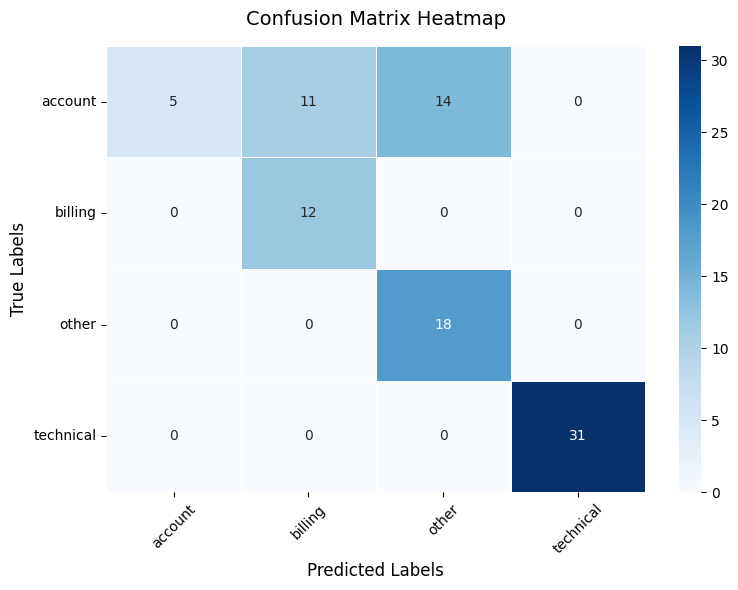

In [73]:
# Manually define the mapping
label_map = {
    0: "account",
    1: "billing",
    2: "other",
    3: "technical"
}

# Get predictions from the trainer
# Use the standard Trainer for prediction
standard_trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer, eval_dataset=test_dataset)
predictions = standard_trainer.predict(test_dataset)
true_labels = predictions.label_ids
pred_labels = predictions.predictions.argmax(-1)


# Decode numeric labels using the map
decoded_true = [label_map[i] for i in true_labels]
decoded_pred = [label_map[i] for i in pred_labels]

# Print mapping
print("===== LABEL ENCODER MAPPING =====")
for k, v in label_map.items():
    print(f"{k} → {v}")

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

print("\n===== CLASSIFICATION REPORT =====")
report = classification_report(decoded_true, decoded_pred, target_names=list(label_map.values()))
print(report)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# 1️⃣ Compute the confusion matrix
cm = confusion_matrix(decoded_true, decoded_pred, labels=list(label_map.values()))
cm_df = pd.DataFrame(cm, index=list(label_map.values()), columns=list(label_map.values()))
print("\n===== CONFUSION MATRIX =====")
print(cm_df)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=0.5)
plt.title("Confusion Matrix Heatmap", fontsize=14, pad=15)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Comment On Performance: **
*   Accuracy	0.93	The model correctly predicted 93% of all test tickets — solid generalization.

*  Macro avg F1	0.93	Balanced average of all classes — shows consistent performance across categories.
* Weighted avg F1	0.93	Takes into account class size — confirms strong, balanced performance overall.  



# Checking for Data Leakeage
Inspecting if the model leant the patterns in the dataset in the train split  or just copy and pasted datasets in the test split.

In [39]:
set(train_df['text']).intersection(set(test_df['text']))

set()

# Verification of Label Encoder Mapping

In [16]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Example: assume your dataset column for labels is 'rock_type'
y = df['label']

# Initialize and fit encoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y)

# Get mapping
class_names = label_encoder.classes_

# Show what each encoded number represents
print("===== VERIFIED LABEL ENCODER MAPPING =====")
for i, name in enumerate(class_names):
    print(f"{i} → {name}")

# (Optional) Check sample side-by-side to confirm match
mapping_check = pd.DataFrame({
    'Original_Label': y,
    'Encoded_Value': encoded_y
}).drop_duplicates().sort_values('Encoded_Value')

print("\n===== SAMPLE CHECK =====")
print(mapping_check)


===== VERIFIED LABEL ENCODER MAPPING =====
0 → 0
1 → 1
2 → 2
3 → 3

===== SAMPLE CHECK =====
   Original_Label  Encoded_Value
6               0              0
2               1              1
0               2              2
4               3              3


ML Flow Integration

In [17]:
# ============================
# MLflow tracking integration
# ============================

# Start a parent MLflow run for DistilBERT fine-tuning
with safe_start_run("DistilBERT Fine-tuning") as parent_run:
    # Example: log training parameters (you can add more)
    mlflow.log_param("model_name", "distilbert-base-uncased")
    mlflow.log_param("epochs", training_args.num_train_epochs)
    mlflow.log_param("learning_rate", training_args.learning_rate)
    mlflow.log_param("batch_size", training_args.per_device_train_batch_size)

    # After model training and evaluation, log metrics
    # (Assuming 'metrics' dictionary exists after evaluation)
    if 'metrics' in locals():
        for key, value in metrics.items():
            if isinstance(value, (int, float)):
                mlflow.log_metric(key, value)

    # Optionally log confusion matrix or reports if available
    if os.path.exists("confusion_matrix.png"):
        mlflow.log_artifact("confusion_matrix.png")

    if os.path.exists("classification_report.txt"):
        mlflow.log_artifact("classification_report.txt")

    print("MLflow logging completed for DistilBERT fine-tuning.")


MLflow logging completed for DistilBERT fine-tuning.


In [74]:
model.save_pretrained("./03_finetune_distilBERT")
tokenizer.save_pretrained("./03_finetune_distilBERT")


('./03_finetune_distilBERT/tokenizer_config.json',
 './03_finetune_distilBERT/special_tokens_map.json',
 './03_finetune_distilBERT/vocab.txt',
 './03_finetune_distilBERT/added_tokens.json',
 './03_finetune_distilBERT/tokenizer.json')

In [77]:
#!zip -r 03_finetune_distilBERT_model.zip /content/03_finetune_distilBERT


  adding: content/03_finetune_distilBERT/ (stored 0%)
  adding: content/03_finetune_distilBERT/tokenizer.json (deflated 71%)
  adding: content/03_finetune_distilBERT/special_tokens_map.json (deflated 42%)
  adding: content/03_finetune_distilBERT/config.json (deflated 50%)
  adding: content/03_finetune_distilBERT/model.safetensors (deflated 8%)
  adding: content/03_finetune_distilBERT/vocab.txt (deflated 53%)
  adding: content/03_finetune_distilBERT/tokenizer_config.json (deflated 75%)
